# Marble Signatures: classification

The following is intended to be part of the documentation of central backend functionality of the Marble Signatures project:
A Jupyter Notebook is chosen to provide an interactive medium for communicating  the exact procedures used for classifying data input to the website.

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In column "MARBLE GROUP basic", the class names of the samples are given. 
We can get an array of each unique class like this:

In [76]:

db = pd.read_excel('1_DB_Basic_dec_24.xlsx')

classes = db["MARBLE GROUP basic"].unique()

print('Number of unique classes: ', len(classes))

rng = np.random.default_rng()
print('Five random classes: ', rng.permutation(classes)[:5])

# Demo: Filtering for classes beginning with A or alphabetically before Ephesos2
filtered_classes = [c for c in classes if c[0] == 'A' or c < 'Ephesos2']
print("Classes beginning with A or alphabetically before Ephesos2: ", filtered_classes)


Number of unique classes:  14
Five random classes:  ['Carrara' 'Göktepe3' 'ParosCho' 'ThasosAl' 'Göktepe4']
Classes beginning with A or alphabetically before Ephesos2:  ['Afyon', 'Aphrodisias', 'Carrara', 'Ephesos1']


Accessing data from the db works like this: 

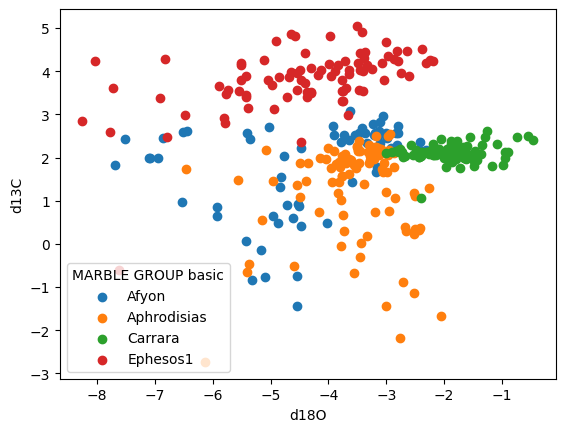

In [77]:
for class_name in filtered_classes:

    # class mask is a boolean vector of the length of the db column used here
    class_mask = db['MARBLE GROUP basic'] == class_name

    # class mask is used to index the pandas DataFrame
    plt.scatter(
        db.loc[class_mask, "d18O"], 
        db.loc[class_mask, "d13C"], 
        label=class_name)

plt.xlabel('d18O')
plt.ylabel('d13C')
plt.legend(title='MARBLE GROUP basic')
plt.show()

The following code allows drawing confidence ellipses and is taken from: https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html

In [78]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

Here, we show how the confidence ellipses are drawn around the LDA-transformed data. We can see that filtering is already crucial with this small number of classes, as overlaps already happen in many cases here. 

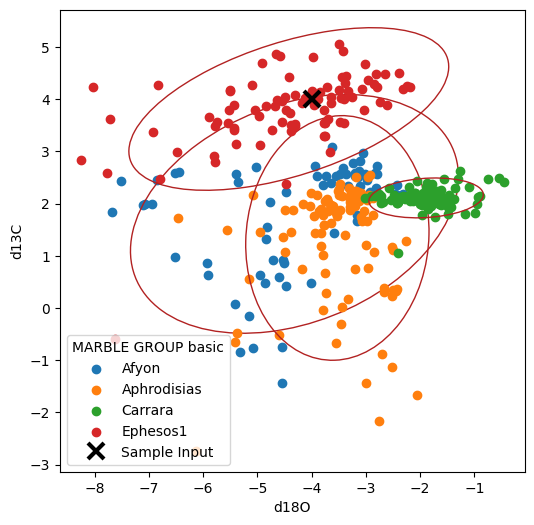

In [80]:
fig, ax = plt.subplots(figsize=(6, 6))

# scaling factor for 90 % confidence ellipses, following this page https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/
# in the confidence ellipse algorithm, each axis is scaled by 2 * n_std * standard_deviation
n_std = np.sqrt(4.605)

for class_name in filtered_classes:
    class_mask = db["MARBLE GROUP basic"] == class_name
    plt.scatter(
        db.loc[class_mask, "d18O"], 
        db.loc[class_mask, "d13C"], 
        label=class_name)
    confidence_ellipse(
        db.loc[class_mask, "d18O"], 
        db.loc[class_mask, "d13C"],  
        ax, 
        n_std=n_std, 
        edgecolor='firebrick')
    
test_values = [[-4, 4]]
plt.plot(test_values[0][0], test_values[0][1], "kx", label="Sample Input", ms=12, mew=3)
plt.xlabel('d18O')
plt.ylabel('d13C')
plt.legend(title='MARBLE GROUP basic')
plt.show()

In [43]:
class_mask = np.isin(db["MARBLE GROUP basic"], filtered_classes)
X = np.column_stack((db.loc[class_mask,"d18O"], db.loc[class_mask, "d13C"]))
y = np.array(db.loc[class_mask, "MARBLE GROUP basic"])
clf = LinearDiscriminantAnalysis()
clf.fit(X, y)
print("Predicted class:", clf.predict(test_values)[0], "\n")
print("Probabilities:")
print("-------------")
probabilities = clf.predict_proba(test_values)
for i in range(len(probabilities[0])):
    print(clf.classes_[i], ":", round(probabilities[0][i] * 100, 2), "%")

Predicted class: Ephesos1 

Probabilities:
-------------
Afyon : 1.97 %
Aphrodisias : 0.25 %
Carrara : 0.2 %
Ephesos1 : 97.58 %
